# Is it a banger?

In [110]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import os

In [1]:
import glob
import tensorflow as tf
from tensorflow.contrib import ffmpeg

In [5]:
def load(fname):
    binary = tf.read_file(fname)
    return ffmpeg.decode_audio(binary, file_format='mp3', samples_per_second=44100, channel_count=2)   

In [6]:
## TODO: audio already clipped into individual files
## TODO: variable padding
def preprocess(audio, seconds_per_sample=0.1, rate=44100):
    
    # pad to a with 1 second of silence front and back
    front = tf.zeros([rate, 2], dtype=audio.dtype)
    back = tf.zeros([rate - tf.mod(tf.shape(audio)[0], rate) + rate, 2], dtype=audio.dtype)
    audio = tf.concat([front, audio, back], 0)

    # normalize to 0 to 1 range
    audio = tf.add(audio, tf.abs(tf.reduce_min(audio)))
    audio = tf.multiply(audio, 1.0 / tf.reduce_max(audio))
    # [data, channels] => [samples, data, channels]
    audio = tf.reshape(audio, [-1, int(rate * seconds_per_sample), 2])
    return audio

In [99]:
training_data_glob = '../data/train/*.mp3'
files = glob.glob(training_data_glob)
file = files[0]
audio = load(file)
audio = preprocess(audio)

In [122]:
filenames = glob.glob(training_data_glob)
save_dir = '../data/train/numpy/'
sess = tf.InteractiveSession()

def save_files(filenames, save_dir):
    for fname in filenames:
        audio = load(fname)
        audio = preprocess(audio, 0.1, 44100)
        audio_array = audio.eval()
        for clip in range(audio_array.shape[0]):
            outfile_str = save_dir + os.path.basename(fname) + '_clip_%d' % clip
            np.save(outfile_str, audio_array[clip, :, :])
            
save_files(filenames, save_dir)

In [100]:
audio

<tf.Tensor 'Reshape:0' shape=(?, 4410, 2) dtype=float32>

In [89]:
sess = tf.InteractiveSession()
audio_array = audio.eval()

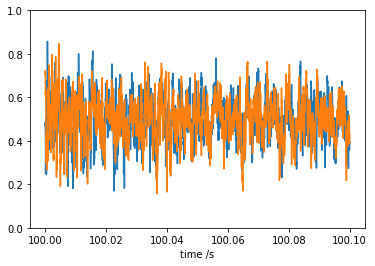

In [121]:
def plot_clip(fname, clip, seconds_per_sample):
    audio_array = np.load(save_dir + os.path.basename(fname) + '_clip_%d.npy' % clip)
    start = clip * seconds_per_sample
    end = start + seconds_per_sample
    t = np.linspace(start, end, len(audio_array[:, 0]))
    plt.plot(t, audio_array[:, 0])
    plt.plot(t, audio_array[:, 1])
    plt.ylim([0, 1])
    plt.xlabel('time /s')
    plt.show()

plot_clip(filenames[0], 1000, 0.1)

In [3]:
training_data_glob = '../data/train/*.mp3'

tf.reset_default_graph()
with tf.Graph().as_default():
    # take files one by one and read data from them
    files = glob.glob(training_data_glob)    
    queue = tf.train.string_input_producer(files, num_epochs=1)
    fname = queue.dequeue()
    audio = load(fname)
    audio = preprocess(audio)
    samples = tf.train.slice_input_producer([audio], num_epochs=1)
    batch = tf.train.batch(samples, 10)

    model = tf.identity(batch) # do nothing

    init = [tf.global_variables_initializer(), tf.local_variables_initializer()]

    coord = tf.train.Coordinator()

    with tf.Session() as session:
        session.run(init)
        threads = tf.train.start_queue_runners(sess=session, coord=coord)
        for _ in range(10):
            try:
                result = session.run(model)
                print(batch)
            except tf.errors.OutOfRangeError:
                print('Error')
                coord.request_stop()
        coord.request_stop()
        coord.join(threads)

NameError: name 'load' is not defined

In [8]:
training_data_glob = '../data/train/*.mp3'

tf.reset_default_graph()
with tf.Graph().as_default():
    # take files one by one and read data from them
    files = glob.glob(training_data_glob)    
    queue = tf.train.string_input_producer(files, num_epochs=None)
    fname = queue.dequeue()
    audio = load(fname)
    audio = preprocess(audio)
    samples = tf.train.slice_input_producer([audio], num_epochs=None)
    batch = tf.train.batch(samples, 10)

    model = tf.identity(batch) # do nothing

    init = [tf.global_variables_initializer(), tf.local_variables_initializer()]

    coord = tf.train.Coordinator()

    with tf.Session() as session:
        session.run(init)
        threads = tf.train.start_queue_runners(sess=session, coord=coord)
        arr = samples[0].eval()
        for _ in range(10):
            try:
                result = session.run(model)
                print(batch.eval())
            except tf.errors.OutOfRangeError:
                print('OutOfRangeError')
                coord.request_stop()
        coord.request_stop()
        coord.join(threads)

[[[ 0.47797358  0.40630198]
  [ 0.48043031  0.40489814]
  [ 0.4811475   0.39575797]
  ..., 
  [ 0.35785457  0.41376364]
  [ 0.41062027  0.43729305]
  [ 0.39499503  0.40543219]]

 [[ 0.44512093  0.24942397]
  [ 0.48648813  0.28505379]
  [ 0.49127945  0.23540093]
  ..., 
  [ 0.51633477  0.32217899]
  [ 0.50725567  0.32271305]
  [ 0.50139624  0.32712293]]

 [[ 0.49936673  0.50225067]
  [ 0.49828336  0.50070953]
  [ 0.50402075  0.50412756]
  ..., 
  [ 0.50508893  0.50533307]
  [ 0.50016022  0.50055695]
  [ 0.49993134  0.49976349]]

 ..., 
 [[ 0.3534905   0.34949264]
  [ 0.35812923  0.35541314]
  [ 0.36244753  0.3610895 ]
  ..., 
  [ 0.56211185  0.5615778 ]
  [ 0.55994511  0.55982304]
  [ 0.55858701  0.55890745]]

 [[ 0.35841915  0.42154574]
  [ 0.39537653  0.44013125]
  [ 0.35655755  0.37100786]
  ..., 
  [ 0.44679943  0.53308922]
  [ 0.48174256  0.53519493]
  [ 0.50312048  0.52193481]]

 [[ 0.60822457  0.59905398]
  [ 0.60720229  0.60109866]
  [ 0.65818268  0.64551765]
  ..., 
  [ 0.55088

[[[ 0.59156179  0.60120547]
  [ 0.62175936  0.63686579]
  [ 0.64048219  0.65828943]
  ..., 
  [ 0.59472036  0.67354852]
  [ 0.60555428  0.68174255]
  [ 0.6322118   0.70086217]]

 [[ 0.59974056  0.72066838]
  [ 0.59465933  0.74689859]
  [ 0.56395823  0.74685282]
  ..., 
  [ 0.34219882  0.31046006]
  [ 0.25171283  0.19768062]
  [ 0.24812695  0.18133822]]

 [[ 0.54493016  0.45105669]
  [ 0.59038681  0.49610132]
  [ 0.61680019  0.52317083]
  ..., 
  [ 0.28056765  0.29605553]
  [ 0.26257727  0.26845199]
  [ 0.2728008   0.27078661]]

 ..., 
 [[ 0.49839017  0.49924466]
  [ 0.50287628  0.5022049 ]
  [ 0.50409704  0.50243378]
  ..., 
  [ 0.50890368  0.50228119]
  [ 0.49932095  0.49306479]
  [ 0.49668118  0.49137101]]

 [[ 0.70003814  0.78892195]
  [ 0.72376591  0.77933925]
  [ 0.74985886  0.77926302]
  ..., 
  [ 0.64460212  0.54105437]
  [ 0.62990767  0.5162127 ]
  [ 0.63526356  0.50807965]]

 [[ 0.33748379  0.34071872]
  [ 0.36882582  0.36446172]
  [ 0.43677422  0.44057372]
  ..., 
  [ 0.60479